# *Optical Tweezers* | Lab-Session #5
## Feb-21-2021 13:45

This jupyter notebook is a used to collect and analyse data during today's lab session

In [1]:
# Import the relevant libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.constants as const
import scipy.signal
import os
from csvlib import *
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.signal import butter, lfilter, freqz
import scipy as sp
from scipy.interpolate import splrep, splev

from IPython.display import display
from PIL import Image
from tqdm import tqdm

# Butterworth Filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

# Display mpl in notebook format
%matplotlib inline

# Data Collection
    
About experiment: a stuck beads sample was driven along x at one y position (approximately through the center of the bead).


In [2]:
# open CSV files to numpy array
csvs = list_csv(PRINT='True')       # Lists CSV files in a given directory
    
indx = 3                           # Which CSV file to view

DATA = pd.read_csv(csvs[indx])     # Gets the CSV file as a Pandas Data Frame

data = DATA.to_numpy().T            # Gets data as a numpy array
    
QPD_x = data[0]
QPD_y = data[1]
QPD_z = data[2]
    
stage_x = data[3]
stage_y = data[4]
    
# DATA                            # Prints pretty PANDAS data frame

List of .csv files in .
	 0 : FEB-20-2021 (root).csv
	 1 : QPD-CAL-100-0.3.csv
	 2 : QPD-CAL-100.csv
	 3 : QPD-CAL-150-0.3.csv
	 4 : QPD-CAL-150.csv
	 5 : QPD-CAL-200-0.3.csv
	 6 : QPD-CAL-200.csv
	 7 : QPD-CAL-250-0.3.csv
	 8 : QPD-CAL-250.csv
	 9 : QPD-CAL-300-0.3.csv


# Data Analysis

Data set under consideration: QPD-CAL-150-0.3.csv


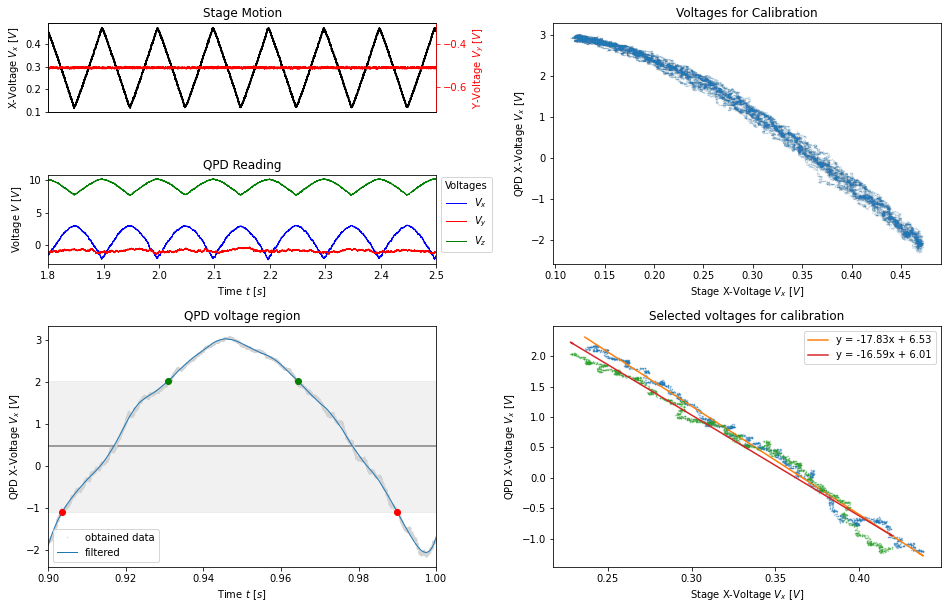

In [21]:
print("Data set under consideration: "+csvs[indx])
 
# important parameters
 
intv = 5 # time interval of data collection (in seconds)
entr = len(QPD_x) # number of entries in one dataset
 
time = np.linspace(0,intv,entr)
# freq 10 Hz, period 0.1 s
 
# Select time window to view
start_time = 1.8
end_time = 2.5
 
# Select time region to fit
bgn_t = 0.9
end_t = 1.0
 
# Create a figure ############################################## 
fig = plt.figure(figsize = (16,10), constrained_layout = False)
gs = fig.add_gridspec(4,2)
 
spc_LR = 0.3
spc_UD = 0.7
fig.subplots_adjust(wspace=spc_LR,hspace=spc_UD)
 
# Section 1 - broad ############################################## 

# Plot Stage Displacement ######################################
ax_stg = fig.add_subplot(gs[0,0])
ax_stg.set_title('Stage Motion')
ax_stg.set_xlim(start_time,end_time)

# Plot V_x
ax_stg.plot(time,stage_x,c='k')
ax_stg.set_ylabel(r'X-Voltage $V_x\ [V]$')
ax_stg.get_xaxis().set_visible(False)

#Plot V_y
ax_stgy = ax_stg.twinx()
ax_stgy.plot(time,stage_y,c='r')

scale_y = 0.2
ax_stgy.set_ylim(min(stage_y)-scale_y,max(stage_y)+scale_y)

ax_stgy.spines['right'].set_color('red')
ax_stgy.tick_params(axis='y', colors ='red')
ax_stgy.set_ylabel(r'Y-Voltage $V_y\ [V]$',c='red')


#scale = 1.05
#offset = -1
#m = max(stage_y)*(scale-1)/scale + min(stage_y)*(2-scale)/scale + offset
#M = max(stage_y) + min(stage_y)*(scale-1)/scale 

# Plot QPD Signal ###############################################
ax_qpd = fig.add_subplot(gs[1,0],sharex = ax_stg)
ax_qpd.set_title('QPD Reading')
ax_qpd.set_xlabel(r'Time $t\ [s]$')
ax_qpd.set_ylabel(r'Voltage $V\ [V]$')

ax_qpd.plot(time,QPD_x,c='b',label=r'$V_x$',lw=1)
ax_qpd.plot(time,QPD_y,c='r',label=r'$V_y$',lw=1)
ax_qpd.plot(time,QPD_z,c='g',label=r'$V_z$',lw=1)

ax_qpd.legend(title='Voltages', bbox_to_anchor=(1., 1.03), loc='upper left')

# Plot Voltages for Calibration ################################
ax_CAL = fig.add_subplot(gs[:2,1])
ax_CAL.set_title('Voltages for Calibration')
ax_CAL.set_xlabel(r'Stage X-Voltage $V_x\ [V]$')
ax_CAL.set_ylabel(r'QPD X-Voltage $V_x\ [V]$')
 
#ax_CAL.set_xlim(start_time,end_time)

start = int(start_time*entr/intv)
end = int(end_time*entr/intv)
 
ax_CAL.plot(stage_x[start:end],QPD_x[start:end],'.',ms=0.05)
 

# Section 2 - zoom in ############################################## 
 
# selected region
 
bgn = int(bgn_t*entr/intv)
ennd = int(end_t*entr/intv)
 
# select data
x = time [bgn:ennd]
y = QPD_x [bgn:ennd]

m = min(QPD_x[bgn:ennd])
M = max(QPD_x[bgn:ennd])

perc = (M - m)*0.20 # 'linear' region will be 20%-80%

# Plot Chosen QPD voltage region ################################

# current method for finding the linear region may not be generalizable

ax_Xfit = fig.add_subplot(gs[2:,0])
ax_Xfit.set_title('QPD voltage region')
ax_Xfit.set_xlim(bgn_t,end_t)
ax_Xfit.set_xlabel(r'Time $t\ [s]$')
ax_Xfit.set_ylabel(r'QPD X-Voltage $V_x\ [V]$')

# display data
ax_Xfit.plot(x, y,'.', label = 'obtained data',c='lightgrey',ms=1)

# display selected linear section
ax_Xfit.hlines([(M+m)/2],bgn_t, end_t, color='grey')
ax_Xfit.axhspan(m+perc,M-perc, color='lightgrey',alpha=0.3)
 
# filter data to find intersections
y_f = sp.signal.savgol_filter(y, window_length=2001, polyorder=5, deriv=0)
ax_Xfit.plot(x,y_f,lw=1,label='filtered')
 
# find intersections of data w/ horizontal boundaries
y_min = np.repeat(m+perc,ennd-bgn)
y_max = np.repeat(M-perc,ennd-bgn)

indx_min = np.argwhere(np.diff(np.sign(y_f - y_min))).flatten()
ax_Xfit.plot(x[indx_min], y_min[indx_min], 'ro')

indx_max = np.argwhere(np.diff(np.sign(y_f - y_max))).flatten()
ax_Xfit.plot(x[indx_max], y_max[indx_max], 'go')

ax_Xfit.legend(loc=3)
 
# organize list of min and max
list_min = list(indx_min)
list_max = list(indx_max)

# make sure min - max are really connected regions
# alternatively, can make sure time interval is indeed an int # periods?

if list_min[0]<list_max[0] and list_min[1]<list_max[0]:
    list_min.pop(0)
if list_min[-1]>list_max[-1] and list_min[-2]>list_max[-1]:
    list_min.pop()
if list_max[0]<list_min[0] and list_max[1]<list_min[0]:
    list_max.pop(0)
if list_max[-1]>list_min[-1] and list_max[-2]>list_min[-1]:
    list_max.pop()
    
# Plot & Fit Voltages ################################
 
ax_FIT = fig.add_subplot(gs[2:,1])
ax_FIT.set_title('Selected voltages for calibration')
ax_FIT.set_xlabel(r'Stage X-Voltage $V_x\ [V]$')
ax_FIT.set_ylabel(r'QPD X-Voltage $V_x\ [V]$')
 
for i in range (len(list_min)):
    
    min_lcl = min(list_min[i],list_max[i])
    max_lcl = max(list_min[i],list_max[i])
    
    x_lcl = stage_x[min_lcl:max_lcl]
    y_lcl = QPD_x[min_lcl:max_lcl]
    
    
    ax_FIT.plot(x_lcl,y_lcl,'.',ms=1,alpha = 0.4)
    
    m, b = np.polyfit(x_lcl, y_lcl, 1)
    
    ax_FIT.plot(x_lcl,m*x_lcl+b, label = 'y = '+str(round(m,2))+'x + '+str(round(b,2)))
    ax_FIT.legend(loc=1)

Amplitude:  0.3


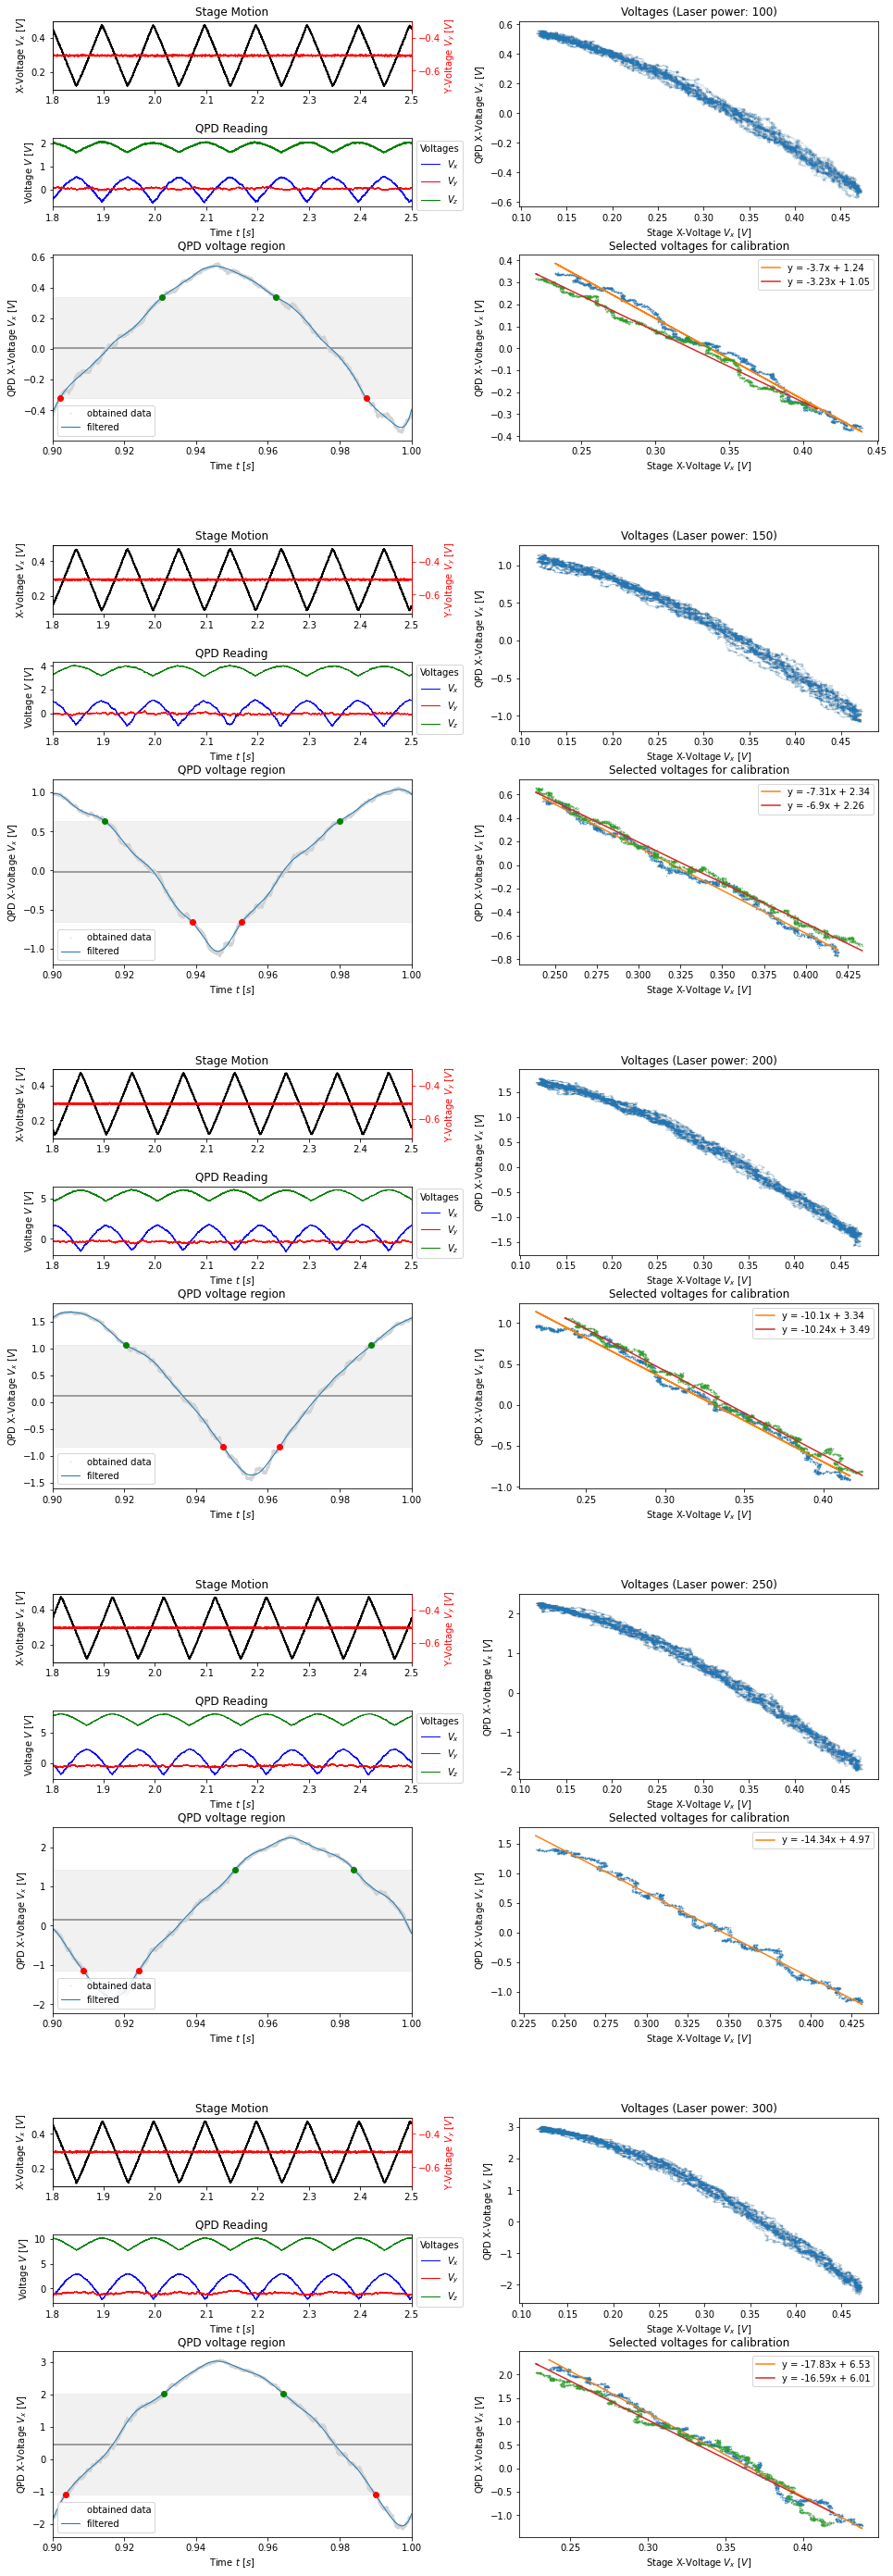

In [4]:
# all together

# Plot multiple indexes

# select amplitude

ampl = 0.3
#ampl = 0.1         # is this correct??

if ampl == 0.3:
    indcs = [1,3,5,7,9]
else:
    indcs = [2,4,6,8]
    
# Create a figure ##############################################
fig = plt.figure(figsize = (16,10*len(indcs)), constrained_layout = False)
fig.tight_layout()
gs = fig.add_gridspec(len(indcs),1,hspace=0.25)

print('Amplitude: ',ampl)

for i in range(len(indcs)):
    # Select a current and then see a family of curves for it.
    DATA = pd.read_csv(csvs[indcs[i]])# Gets the CSV file as a Pandas Data Frame
    data = DATA.to_numpy().T  # Gets data as a numpy array
    gsi = gs[i].subgridspec(4,2)

    #print('Laser power: ',csvs[indcs[i]].split('-')[2])

    QPD_x = data[0]
    QPD_y = data[1]
    QPD_z = data[2]

    stage_x = data[3]
    stage_y = data[4]

    # important parameters
    intv = 5 # time interval of data collection (in seconds)
    entr = len(QPD_x) # number of entries in one dataset

    time = np.linspace(0,intv,entr)
    # freq 10 Hz, period 0.1 s

    # Select time window to view
    start_time = 1.8
    end_time = 2.5

    # Select time region to fit
    bgn_t = 0.9
    end_t = 1.0

    spc_LR = 0.3
    spc_UD = 0.7
    fig.subplots_adjust(wspace=spc_LR,hspace=spc_UD)

    # Section 1 - broad ############################################## 

    # Plot Stage Displacement ######################################
    ax_stg = fig.add_subplot(gsi[0,0])
    ax_stg.set_title('Stage Motion')
    ax_stg.set_xlim(start_time,end_time)


    # Plot V_x
    ax_stg.plot(time,stage_x,c='k')
    ax_stg.set_ylabel(r'X-Voltage $V_x\ [V]$')
    ax_stg.get_xaxis().set_visible(True)

    #Plot V_y
    ax_stgy = ax_stg.twinx()
    ax_stgy.plot(time,stage_y,c='r')

    scale_y = 0.2
    ax_stgy.set_ylim(min(stage_y)-scale_y,max(stage_y)+scale_y)

    ax_stgy.spines['right'].set_color('red')
    ax_stgy.tick_params(axis='y', colors ='red')
    ax_stgy.set_ylabel(r'Y-Voltage $V_y\ [V]$',c='red')

    #scale = 1.05
    #offset = -1
    #m = max(stage_y)*(scale-1)/scale + min(stage_y)*(2-scale)/scale + offset
    #M = max(stage_y) + min(stage_y)*(scale-1)/scale

    # Plot QPD Signal ###############################################
    ax_qpd = fig.add_subplot(gsi[1,0],sharex = ax_stg)
    ax_qpd.set_title('QPD Reading')
    ax_qpd.set_xlabel(r'Time $t\ [s]$')
    ax_qpd.set_ylabel(r'Voltage $V\ [V]$')

    ax_qpd.plot(time,QPD_x,c='b',label=r'$V_x$',lw=1)
    ax_qpd.plot(time,QPD_y,c='r',label=r'$V_y$',lw=1)
    ax_qpd.plot(time,QPD_z,c='g',label=r'$V_z$',lw=1)

    ax_qpd.legend(title='Voltages', bbox_to_anchor=(1., 1.03), loc='upper left')

    # Plot Voltages for Calibration ################################
    ax_CAL = fig.add_subplot(gsi[:2,1])
    ax_CAL.set_title('Voltages ('+'Laser power: '+csvs[indcs[i]].split('-')[2]+')')
    ax_CAL.set_xlabel(r'Stage X-Voltage $V_x\ [V]$')
    ax_CAL.set_ylabel(r'QPD X-Voltage $V_x\ [V]$')

    #ax_CAL.set_xlim(start_time,end_time)

    start = int(start_time*entr/intv)
    end = int(end_time*entr/intv)

    ax_CAL.plot(stage_x[start:end],QPD_x[start:end],'.',ms=0.05)

    # Section 2 - zoom in ############################################## 

    # selected region

    bgn = int(bgn_t*entr/intv)
    ennd = int(end_t*entr/intv)

    # select data
    x = time [bgn:ennd]
    y = QPD_x [bgn:ennd]

    m = min(QPD_x[bgn:ennd])
    M = max(QPD_x[bgn:ennd])

    perc = (M - m)*0.20 # 'linear' region will be 20%-80%

    # Plot Chosen QPD voltage region ################################

    ax_Xfit = fig.add_subplot(gsi[2:,0])
    ax_Xfit.set_title('QPD voltage region')
    ax_Xfit.set_xlim(bgn_t,end_t)
    ax_Xfit.set_xlabel(r'Time $t\ [s]$')
    ax_Xfit.set_ylabel(r'QPD X-Voltage $V_x\ [V]$')

    # display data
    ax_Xfit.plot(x, y,'.', label = 'obtained data',c='lightgrey',ms=1)

    # display selected linear section
    ax_Xfit.hlines([(M+m)/2],bgn_t, end_t, color='grey')
    ax_Xfit.axhspan(m+perc,M-perc, color='lightgrey',alpha=0.3)

    # filter data to find intersections
    y_f = sp.signal.savgol_filter(y, window_length=2001, polyorder=5, deriv=0)
    ax_Xfit.plot(x,y_f,lw=1,label='filtered')

    # find intersections of data w/ horizontal boundaries
    y_min = np.repeat(m+perc,ennd-bgn)
    y_max = np.repeat(M-perc,ennd-bgn)

    indx_min = np.argwhere(np.diff(np.sign(y_f - y_min))).flatten()
    ax_Xfit.plot(x[indx_min], y_min[indx_min], 'ro')

    indx_max = np.argwhere(np.diff(np.sign(y_f - y_max))).flatten()
    ax_Xfit.plot(x[indx_max], y_max[indx_max], 'go')

    ax_Xfit.legend(loc=3)

    # organize list of min and max
    list_min = list(indx_min)
    list_max = list(indx_max)

    # make sure min - max are really connected regions
    if list_min[0]<list_max[0] and list_min[1]<list_max[0]:
        list_min.pop(0)
    if list_min[-1]>list_max[-1] and list_min[-2]>list_max[-1]:
        list_min.pop()
    if list_max[0]<list_min[0] and list_max[1]<list_min[0]:
        list_max.pop(0)
    if list_max[-1]>list_min[-1] and list_max[-2]>list_min[-1]:
        list_max.pop()

    # Plot & Fit Voltages ################################

    ax_FIT = fig.add_subplot(gsi[2:,1])
    ax_FIT.set_title('Selected voltages for calibration')
    ax_FIT.set_xlabel(r'Stage X-Voltage $V_x\ [V]$')
    ax_FIT.set_ylabel(r'QPD X-Voltage $V_x\ [V]$')
    
    for i in range (len(list_min)):
        min_lcl = min(list_min[i],list_max[i])
        max_lcl = max(list_min[i],list_max[i])
        
        x_lcl = stage_x[min_lcl:max_lcl]
        y_lcl = QPD_x[min_lcl:max_lcl]
        
        ax_FIT.plot(x_lcl,y_lcl,'.',ms=1,alpha = 0.5)
        m, b = np.polyfit(x_lcl, y_lcl, 1)
        
        ax_FIT.plot(x_lcl,m*x_lcl+b, label = 'y = '+str(round(m,2))+'x + '+str(round(b,2)))
        ax_FIT.legend(loc=1)


#fig.tight_layout()
#fig.savefig('Plots-0.3.jpg',dpi=200,transparent=False)

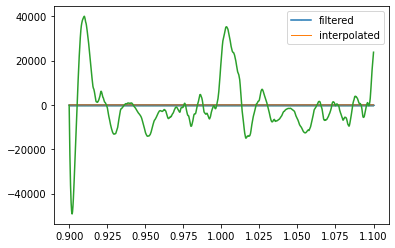

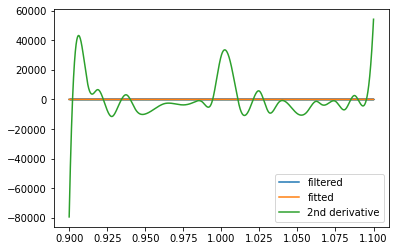

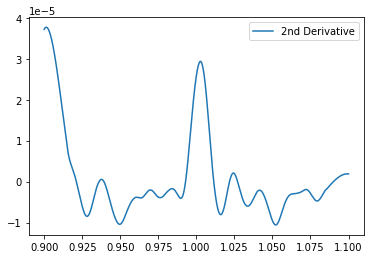

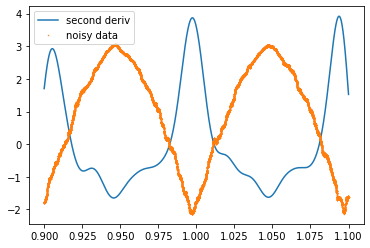

In [13]:
# for documentation purposes
# failed methods 
# to find linear region
 
########################################################
 
# method 1 - didn't work
# use a spline to interpolate curve from data
# spline has a derivative method
 
# needed to filter the data first, used butter lowpass
 
# somehow, derivative is too large
 
bgn_t = 0.9
end_t = 1.1
 
bgn = int(bgn_t*entr/intv)
end = int(end_t*entr/intv)
 
# select data
x = time [bgn:end]
y = QPD_x [bgn:end]
 
# Filter the singal
# Filter parameters
order = 3
fs = len(time)/(max(time)-min(time))# sample rate
cutoff = 50# cutoff frequency
 
# The actual filtering
y_f = butter_lowpass_filter(y, cutoff, fs, order)
 
# interpolate
y_spl = UnivariateSpline(x,y_f,s=0,k=4)
 
#plt.plot(x,y,marker='.',ms=2,label='data')
plt.plot(x,y_f,marker='.',ms=0.1,label='filtered')
plt.plot(x,y_spl(x),lw=1,label='interpolated')
#print(len(x))
 
# take derivative
deriv = y_spl.derivative(n=2)
 
plt.plot(x,deriv(x))
 
#plt.ylim(-5,5)
 
plt.legend()
plt.show()
 
########################################################
 
# method 2 - derivative too large
 
# filter the data with butter lowpass
# determine smooth spline interpolations (just diff spline option than method 1)
 
bgn_t = 0.9
end_t = 1.1
 
bgn = int(bgn_t*entr/intv)
end = int(end_t*entr/intv)
 
# select data
x = time [bgn:end]
y = QPD_x [bgn:end]
 
# interpolate
 
# Filter the singal
# Filter parameters
order = 2
fs = len(time)/(max(time)-min(time))# sample rate
cutoff = 50 # cutoff frequency
 
# The actual filtering
y_f = butter_lowpass_filter(y, cutoff, fs, order)
 
#plt.plot(x,y,marker='.',ms=2,label='data')
plt.plot(x,y_f,marker='.',ms=0.1,label='filtered')
 
#interpolating
f = splrep(x,y_f,k=5,s=3)
 
plt.plot(x, splev(x,f), label='fitted')
#plt.plot(x, splev(x,f,der=1), label='1st derivative')
plt.plot(x, splev(x,f,der=2), label='2nd derivative')
 
plt.legend()
 
plt.show()
 

########################################################
 
#method 3 - sort of worked
# use savgol filter to clean data
# filter automatically finds 2nd derivative
# high window length was necessary to get a trend in 2nd derivative
 
# if butter filter used before savgol, similar results
 
bgn_t = 0.9
end_t = 1.1
 
bgn = int(bgn_t*entr/intv)
end = int(end_t*entr/intv)
 
# select data
x = time [bgn:end]
y = QPD_x [bgn:end]
 
dydx = sp.signal.savgol_filter(y_f, window_length=2901, polyorder=5, deriv=2)
 
# Plot result
#plt.plot(x, y, label='Original signal')
plt.plot(x, dydx*10, label='2nd Derivative')
 
plt.legend()
plt.show()
 
########################################################
 
#method 4 
 
bgn_t = 0.9
end_t = 1.1
 
bgn = int(bgn_t*entr/intv)
end = int(end_t*entr/intv)
 
# select data
x = time [bgn:end]
y = QPD_x [bgn:end]
 
# create convolution kernel for calculating
# the smoothed second order derivative
smooth_width = 6000
x1 = np.linspace(-3,3,smooth_width)
norm = np.sum(np.exp(-x1**2)) * (x1[1]-x1[0]) # ad hoc normalization
y1 = (4*x1**2 - 2) * np.exp(-x1**2) / smooth_width *8#norm*(x1[1]-x1[0])
 
 
 
# calculate second order deriv.
y_conv = np.convolve(y, y1, mode='same')
 
# plot data
plt.plot(x,y_conv, label = 'second deriv')
plt.plot(x, y,'.', label = 'noisy data',ms=1)
#plt.plot(x, y, label='theory')
#plt.plot(x, x, '0.3', label = 'linear data')
 
plt.legend(loc=0)
plt.show()
 
########################################################